In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import math

"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Para usar LaTex no PyPlot
# tive que instalar: > sudo apt-get install cm-super
params = {'text.usetex': True} 
plt.rcParams.update(params)

# Declaração das funções utilizadas

Exponencial simples: $$ Volume = V_{max} \left( 1- e^{(-KP_{aw})} \right) $$

Função densidade de probabilidade: $$ \dfrac{1}{\sigma \sqrt{2\pi}} e^{-\dfrac{1}{2} \left( \dfrac{x-\mu}{\sigma} \right)^2} $$

Função densidade de probabilidade acumulada: integral da f.d.p.

In [3]:
# Modelo exponencial simples de curva PV pulmonar
# Volume = Vmax*(1-e^(-K*Paw))
# Paw = pressão na via aérea
# K = 'constante de tempo' da exponencial
def exponencial_simples(Paw,K,Vmax):
    return Vmax*(1-np.exp(-K*Paw))

# função densidade de probabilidade (curva normal)
# mi: esperança
# sigma: desvio padrão
def fdp(x,mi,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-0.5)*((x-mi)/sigma)**2)

# função densidade de probabilidade acumulada (integral da curva normal)
# mi: esperança
# sigma: desvio padrão
def fda(x,mi,sigma,dt=0.1):
    x_vec = np.arange(mi-6*sigma,x,dt)
    integral = 0
    for x in x_vec:
        integral = integral + fdp(x,mi,sigma)*dt
    return integral

# ajustando a função para uma entrada array (para curve_fit)
def fda_vec(x,mi,sigma,dt=0.1):
    integral_lst = []
    for x_in in x:
        x_vec = np.arange(mi-6*sigma,x_in,dt)
        integral = 0
        for x in x_vec:
            integral = integral + fdp(x_in,mi,sigma)*dt
        integral_lst.append(integral)
    return np.array(integral_lst)

# Modelo sigmoide da curva PV pulmonar
# Segue modelo exponencial, mas Vmax varia com a pressão
# Paw = pressão na via aérea
# K = 'constante de tempo' da exponencial
def modelo_sigmoide(Paw,K,Vmax,mi,sigma):
    Vmax_recrutado = Vmax*fda(Paw,mi,sigma)
    return Vmax_recrutado*(1-np.exp(-K*Paw))

# ajustando a função para uma entrada array (para curve_fit)
def modelo_sigmoide_vec(Paw,K,Vmax,mi,sigma):
    Vmax_recrutado = np.multiply(Vmax,fda_vec(Paw,mi,sigma))
    return Vmax_recrutado*(1-np.exp(-K*Paw))



# Plotando funções usadas
## Modelo exponencial simples

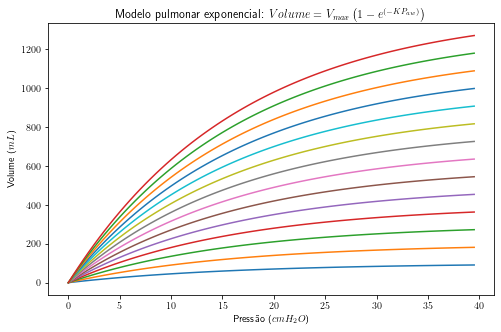

In [4]:
pressoes = np.arange(0,40,0.5)
Vmax_lst = np.arange(100,1500,100)
K = 0.06
plt.figure(figsize=(8,5))
for Vmax in Vmax_lst:
    volumes = [exponencial_simples(Paw,K,Vmax) for Paw in pressoes]
    plt.plot(pressoes,volumes)
plt.xlabel('Pressão ($cmH_2O$)')
plt.ylabel('Volume ($mL$)')
plt.title(r'Modelo pulmonar exponencial: $ Volume = V_{max} \left( 1- e^{(-KP_{aw})} \right) $')
plt.show()

## Probabilidade de novas unidades pulmonares recrutadas

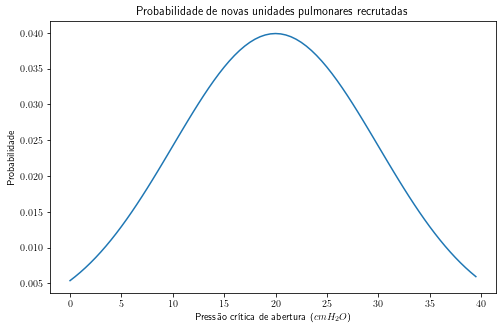

In [5]:
mi = 20
sigma = 10
prob = [fdp(Paw,mi,sigma) for Paw in pressoes]
plt.figure(figsize=(8,5))
plt.plot(pressoes,prob)
plt.xlabel('Pressão crítica de abertura ($cmH_2O$)')
plt.ylabel('Probabilidade')
plt.title('Probabilidade de novas unidades pulmonares recrutadas')
plt.show()

## Probabilidade acumulada de novas unidades pulmonares recrutadas

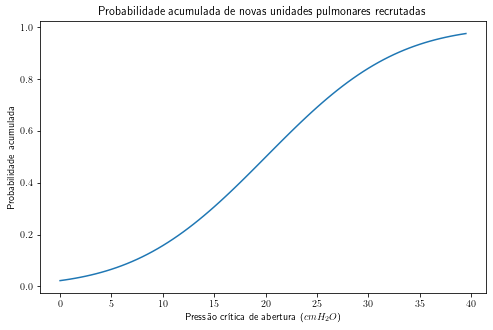

In [6]:
acumulado = [fda(Paw,mi,sigma) for Paw in pressoes]
plt.figure(figsize=(8,5))
plt.plot(pressoes,acumulado)
plt.xlabel('Pressão crítica de abertura ($cmH_2O$)')
plt.ylabel('Probabilidade acumulada')
plt.title('Probabilidade acumulada de novas unidades pulmonares recrutadas')
plt.show()

## Modelo sigmoide simulado

In [7]:
def plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax):
    Vmax_lst = np.arange(Vmax/10,Vmax+1,Vmax/10)
    pressoes = np.arange(0,Pmax,0.5)
    sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

    plt.figure(figsize=(15,5))
    plt1 = plt.subplot(1,2,1)
    for Vmax in Vmax_lst:
        volumes = [exponencial_simples(Paw,K,Vmax) for Paw in pressoes]
        plt.plot(pressoes,volumes,'k:')
    plt.plot(pressoes,sigmoide,label=f'sig: K={K:.3f}, Vmax={Vmax:.0f}, $\\mu$={mi:.1f}, $\\sigma$={sigma:.1f}')
    plt.xlabel('Pressão ($cmH_2O$)')
    plt.ylabel('Volume ($mL$)')
    plt.title(r'Modelo pulmonar sigmoide')
    plt2 = plt.subplot(1,2,2)
    prob = [fdp(Paw,mi,sigma) for Paw in pressoes]
    plt.plot(pressoes,prob)
    plt.xlabel('Pressão crítica de abertura ($cmH_2O$)')
    plt.ylabel('Probabilidade')
    plt.title('Probabilidade de novas unidades pulmonares recrutadas')
    return plt1, plt2

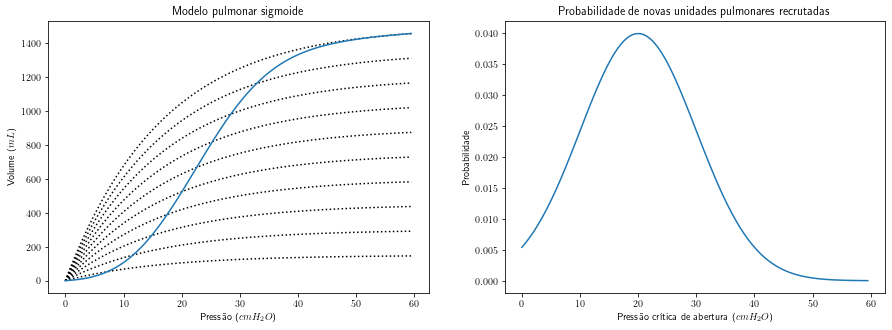

In [8]:
Pmax = 60
Vmax = 1500
K = 0.06
mi = 20
sigma = 10
_= plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)

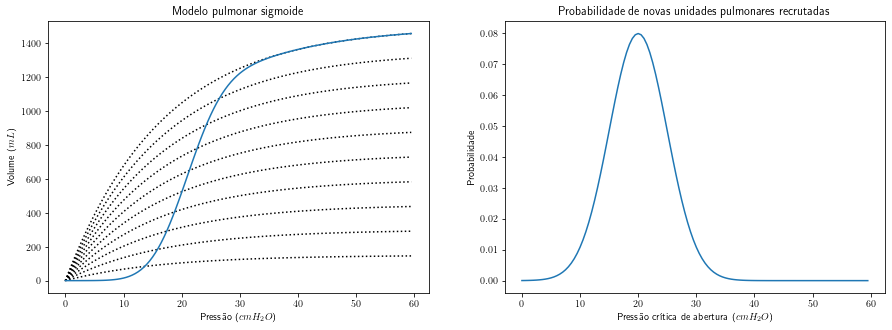

In [9]:
Pmax = 60
Vmax = 1500
K = 0.06
mi = 20
sigma = 5
_= plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)

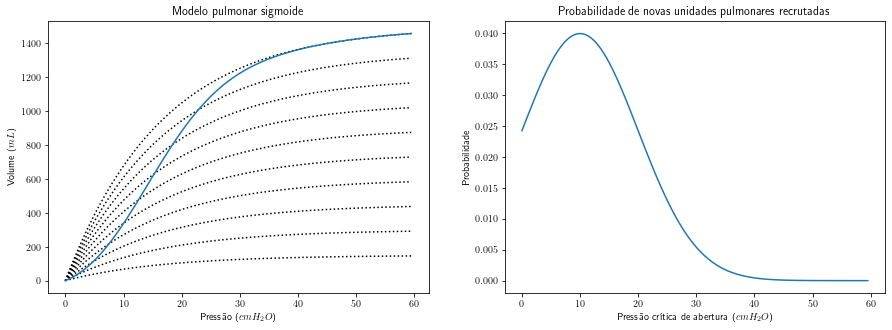

In [10]:
Pmax = 60
Vmax = 1500
K = 0.06
mi = 10
sigma = 10
_= plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)

# Testando ajustes das curvas

## Ajustando o modelo antigo

In [11]:
# função usada para fitar o modelo PV sigmoide (doente)
#                b                                   b
# V(x) = a + ----------------------   = a + ------------------------
#            1 + exp(-(x/d) + (c/d)          1 + exp(-x/d).exp(c/d)
#
# lim (x-> inf)  V(x) = a + b
def sigmoid(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

[-162.22152825 1477.21299387   14.34269231    6.45920543]


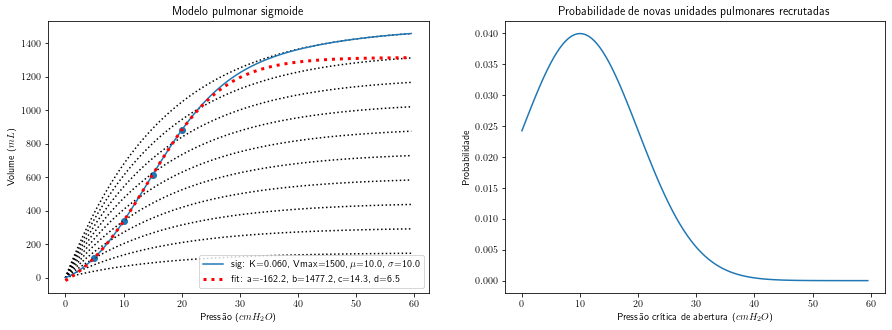

In [12]:
# simulando dados PV
Pmax = 60
Vmax = 1500
K = 0.06
mi = 10
sigma = 10

pressoes = [5, 10, 15, 20]
vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

estimator_lst = ["lm","trf","dogbox"]
estimator = estimator_lst[0]
parameters, pcov = curve_fit(sigmoid, pressoes, vol_sigmoide, method=estimator)
print(parameters)
a,b,c,d = parameters

plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
_= plt1.scatter(pressoes,vol_sigmoide)
vol_sigmoide_fitado = [sigmoid(x,*parameters) for x in range(Pmax)]

_= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:',linewidth=3,label=f'fit: a={a:.1f}, b={b:.1f}, c={c:.1f}, d={d:.1f}')
_= plt1.legend(loc='lower right')

### Outros ajustes...

[ -27.48610933 1047.44763992   19.51171723    4.95657066]


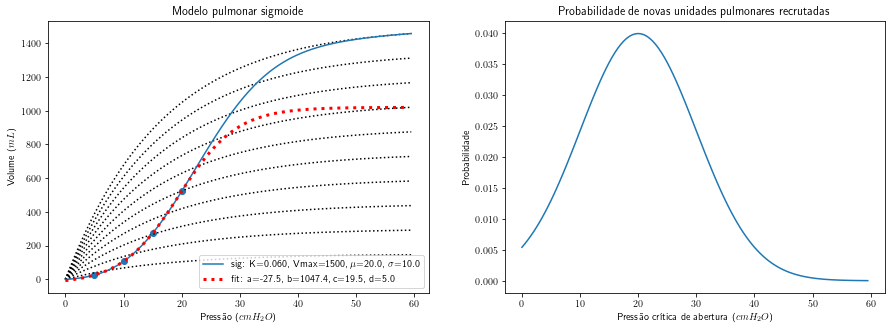

In [13]:
# simulando dados PV
Pmax = 60
Vmax = 1500
K = 0.06
mi = 20
sigma = 10

pressoes = [5, 10, 15, 20]
vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

estimator_lst = ["lm","trf","dogbox"]
estimator = estimator_lst[0]
parameters, pcov = curve_fit(sigmoid, pressoes, vol_sigmoide, method=estimator)
print(parameters)
a,b,c,d = parameters

plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
_= plt1.scatter(pressoes,vol_sigmoide)
vol_sigmoide_fitado = [sigmoid(x,*parameters) for x in range(Pmax)]

_= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:',linewidth=3,label=f'fit: a={a:.1f}, b={b:.1f}, c={c:.1f}, d={d:.1f}')
_= plt1.legend(loc='lower right')

[-322.36267677 1647.98755293   10.60371937    7.13215245]


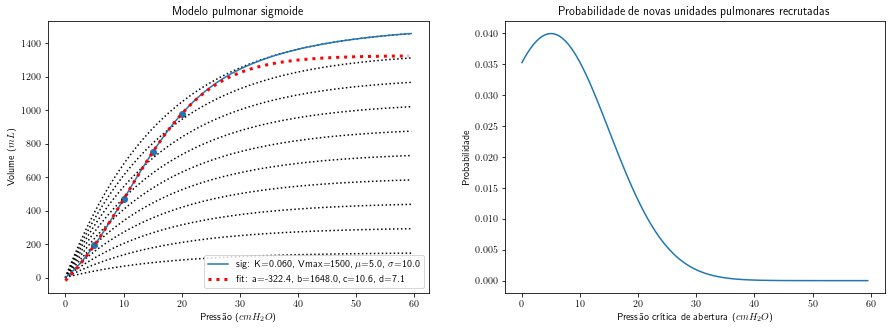

In [14]:
# simulando dados PV
Pmax = 60
Vmax = 1500
K = 0.06
mi = 5
sigma = 10

pressoes = [5, 10, 15, 20]
vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

estimator_lst = ["lm","trf","dogbox"]
estimator = estimator_lst[0]
parameters, pcov = curve_fit(sigmoid, pressoes, vol_sigmoide, method=estimator)
print(parameters)
a,b,c,d = parameters

plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
_= plt1.scatter(pressoes,vol_sigmoide)
vol_sigmoide_fitado = [sigmoid(x,*parameters) for x in range(Pmax)]

_= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:',linewidth=3,label=f'fit: a={a:.1f}, b={b:.1f}, c={c:.1f}, d={d:.1f}')
_= plt1.legend(loc='lower right')

[-113.01271714 1208.11611851   15.51577241    6.41563353]


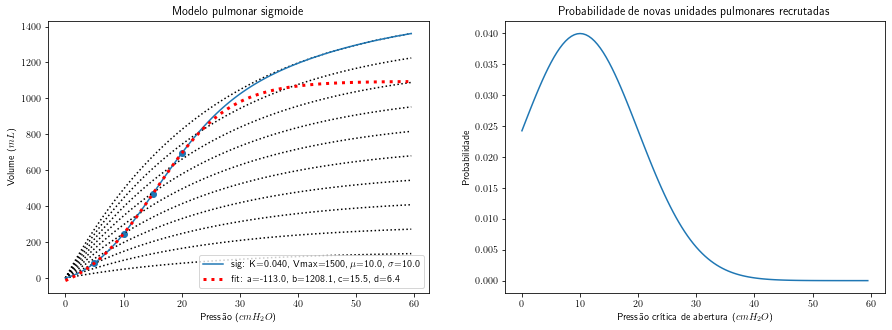

In [15]:
# simulando dados PV
Pmax = 60
Vmax = 1500
K = 0.04
mi = 10
sigma = 10

pressoes = [5, 10, 15, 20]
vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

estimator_lst = ["lm","trf","dogbox"]
estimator = estimator_lst[0]
parameters, pcov = curve_fit(sigmoid, pressoes, vol_sigmoide, method=estimator)
print(parameters)
a,b,c,d = parameters

plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
_= plt1.scatter(pressoes,vol_sigmoide)
vol_sigmoide_fitado = [sigmoid(x,*parameters) for x in range(Pmax)]

_= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:',linewidth=3,label=f'fit: a={a:.1f}, b={b:.1f}, c={c:.1f}, d={d:.1f}')
_= plt1.legend(loc='lower right')

### Só com 3 pontos, sem bound, não ajusta...

[272.00076224 668.45710968  14.89859707   2.19904967]


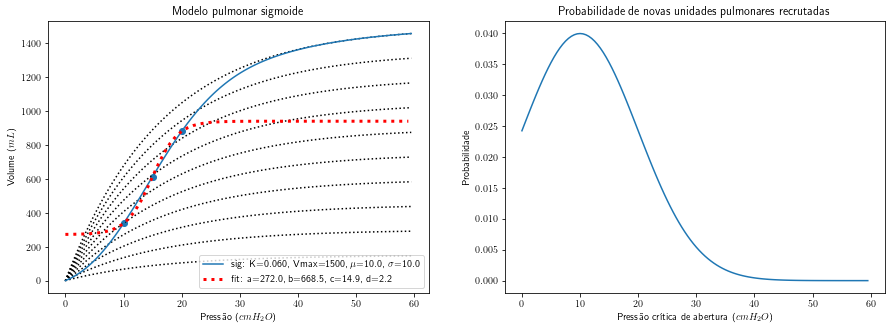

In [16]:
# simulando dados PV
Pmax = 60
Vmax = 1500
K = 0.06
mi = 10
sigma = 10

pressoes = [10, 15, 20]
vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

estimator_lst = ["lm","trf","dogbox"]
estimator = estimator_lst[2]
parameters, pcov = curve_fit(sigmoid, pressoes, vol_sigmoide, method=estimator)
print(parameters)
a,b,c,d = parameters

plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
_= plt1.scatter(pressoes,vol_sigmoide)
vol_sigmoide_fitado = [sigmoid(x,*parameters) for x in range(Pmax)]

_= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:',linewidth=3,label=f'fit: a={a:.1f}, b={b:.1f}, c={c:.1f}, d={d:.1f}')
_= plt1.legend(loc='lower right')

## Brincando com o modelo novo
Não ajusta...  não sei porque... nem com estimativa inicial correta

lm: [  5.2005658  498.01425169  27.94648609  12.62989202]


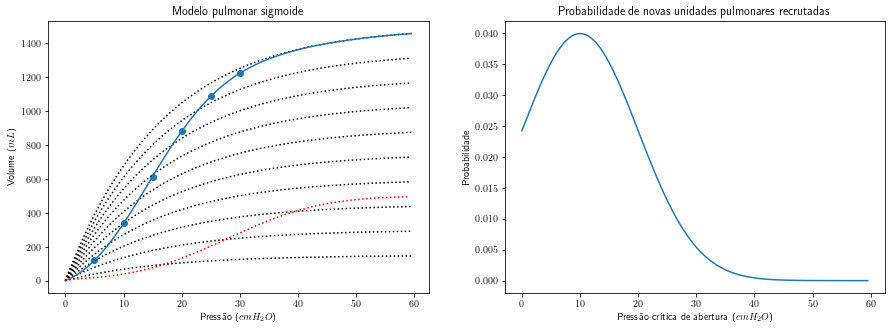

In [17]:
# simulando dados PV
Pmax = 60
Vmax = 1500
K = 0.06
mi = 10
sigma = 10

# estimativa inicial: K,Vmax,mi,sigma
p0 = [0.06, 2000, 10, 10]

pressoes = [5, 10, 15, 20, 25, 30]
vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
_= plt1.scatter(pressoes,vol_sigmoide)

estimator_lst = ["lm","trf","dogbox"]
estimator = estimator_lst[0]
parameters, pcov = curve_fit(modelo_sigmoide_vec, pressoes, vol_sigmoide, p0=p0, method=estimator)
print(f'{estimator}: {parameters}')
K,Vmax,mi,sigma = parameters
vol_sigmoide_fitado = [modelo_sigmoide(x,*parameters) for x in range(Pmax)]
_= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:')

### Fazendo meu próprio ajuste...

Método beeeem lento, mas funciona...

In [18]:
def ajusta_funcao(funcao, X_in, Y_in, p0, maxIter = 100, tolerancia = 0.001):
    passo = 0.03*np.ones(len(p0))
    Y_estimado = [funcao(x, *p0) for x in X_in]
    erro_inicial = mean_squared_error(np.array(Y_in), np.array(Y_estimado),squared=False)
    parametros = p0
    erro = erro_inicial
    for iteracao in range(maxIter):
        if iteracao % 10 == 0:
            print(f'\rIteracao {iteracao} de {maxIter}. Erro: {erro}.\t\t\t', end="")
        erro_antes = erro
        for idx in range(len(parametros)):
            # erro inicial
            Y_estimado0 = [funcao(x, *parametros) for x in X_in]
            erro0 = mean_squared_error(np.array(Y_in), np.array(Y_estimado0),squared=False)
            # aumentando parametro
            parametros_novo1 = np.copy(parametros)
            parametros_novo1[idx] = parametros_novo1[idx]*(1+passo[idx])
            Y_estimado1 = [funcao(x, *parametros_novo1) for x in X_in]
            erro1 = mean_squared_error(np.array(Y_in), np.array(Y_estimado1),squared=False)
            # diminuindo parametro
            parametros_novo2 = np.copy(parametros)
            parametros_novo2[idx] = parametros_novo2[idx]*(1-passo[idx])
            Y_estimado2 = [funcao(x, *parametros_novo2) for x in X_in]
            erro2 = mean_squared_error(np.array(Y_in), np.array(Y_estimado2),squared=False)
            # verificando melhora
            index_min = np.argmin([erro0,erro1,erro2])
            if index_min == 1:
                parametros = parametros_novo1
                #print(f'idx: {idx}; {parametros}; erro: {erro1}; erro_anterior: {erro0}')
            elif index_min == 2:
                parametros = parametros_novo2
                #print(f'idx: {idx}; {parametros}; erro: {erro2}; erro_anterior: {erro0}')
            else:
                passo[idx] = passo[idx]/2
                #print(f'idx: {idx}; {parametros}; mantem erro: {erro0}')
            Y_estimado = [funcao(x, *parametros) for x in X_in]
            erro = mean_squared_error(np.array(Y_in), np.array(Y_estimado),squared=False)
        if (erro_antes-erro) < tolerancia:
            print(f'\nTolerancia atingida em {iteracao} iteracoes. Erro: {erro}. Erro antes: {erro_antes}')
            break
    print('\n')
    return parametros, erro, erro_inicial

In [19]:
# Rodando poucas iterações, só para teste...
Vmax = 2000
K = 0.06
mi = 15
sigma = 15

X = [5, 10, 15, 20, 25, 30]
p0 = [0.05, 1500, 10, 10]

Y = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in X]
parametros, erro, erro_inicial = ajusta_funcao(modelo_sigmoide, X, Y, p0, maxIter = 10)
print(f'{parametros}; erro: {erro}; erro_inicial: {erro_inicial}')

Iteracao 0 de 10. Erro: 133.85576463933938.			

[5.54464903e-02 1.72691190e+03 1.19190397e+01 1.00592105e+01]; erro: 30.306924192849984; erro_inicial: 133.85576463933938


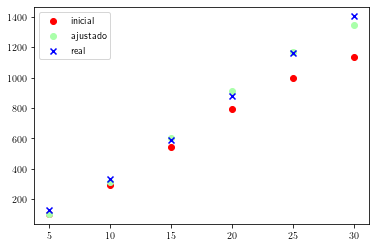

In [20]:
Y_ajustado = [modelo_sigmoide(Paw,*parametros) for Paw in X]
Y_inicial = [modelo_sigmoide(Paw,*p0) for Paw in X]

plt.scatter(X,Y_inicial,c='r',label='inicial')
plt.scatter(X,Y_ajustado,c='#aaffaa',label='ajustado')
plt.scatter(X,Y,c='b',marker='x',label='real')
plt.legend()
plt.show()

# Criando novo modelo para uso com curve_fit()

In [21]:
# ajustando a função para uma entrada array (para curve_fit)
def meu_erf2(Paw,mi,sigma): # parâmetros ajustados empiricamente... ;)
    x = (Paw-mi)/(sigma*1.5)
    merf = math.erf(x)
    return (merf/2)+0.5

def meu_erf2_vec(Paw,mi,sigma):
    saida_lst = []
    for x_in in Paw:
        x = (x_in-mi)/(sigma*1.5)
        merf = math.erf(x)
        saida_lst.append((merf/2)+0.5)
    return np.array(saida_lst)


def modelo_sigmoide_erf(Paw,K,Vmax,mi,sigma):
    Vmax_recrutado = Vmax*meu_erf2(Paw,mi,sigma)
    V = Vmax_recrutado*(1-np.exp(-K*Paw))
    return V


def modelo_sigmoide_erf_vec(Paw,K,Vmax,mi,sigma):
    Vmax_recrutado = Vmax*meu_erf2_vec(Paw,mi,sigma)
    V = Vmax_recrutado*(1-np.exp(-K*Paw))
    return V

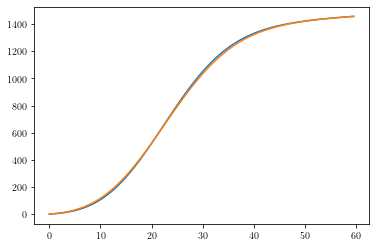

In [22]:
# comparando o modelo com integral e o com erf()
Pmax = 60
Vmax = 1500
K = 0.06
mi = 20
sigma = 10
pressoes = np.arange(0,Pmax,0.5)
sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]
sigmoide2 = [modelo_sigmoide_erf(Paw,K,Vmax,mi,sigma) for Paw in pressoes]
plt.plot(pressoes,sigmoide)
plt.plot(pressoes,sigmoide2)

lm: [5.99999998e-02 1.50000000e+03 1.00500000e+01 9.42805112e+00]


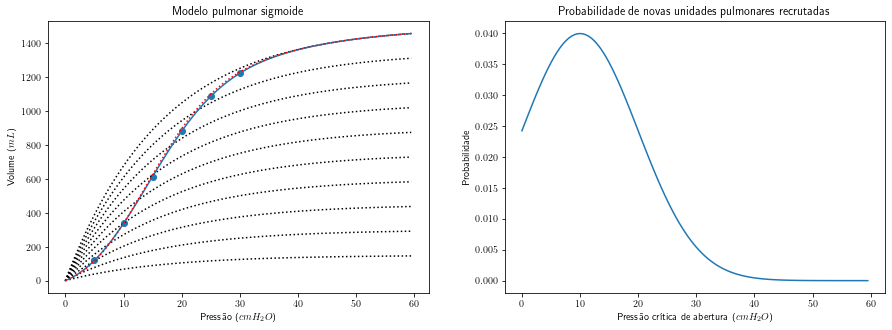

In [23]:
# simulando dados PV
Pmax = 60
Vmax = 1500
K = 0.06
mi = 10
sigma = 10

# estimativa inicial: K,Vmax,mi,sigma
p0 = [0.05, 2000, 10, 10]

pressoes = [5, 10, 15, 20, 25, 30]
vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
_= plt1.scatter(pressoes,vol_sigmoide)

estimator_lst = ["lm","trf","dogbox"]
estimator = estimator_lst[0]
parameters, pcov = curve_fit(modelo_sigmoide_erf_vec, pressoes, vol_sigmoide, p0=p0, method=estimator)
print(f'{estimator}: {parameters}')
K,Vmax,mi,sigma = parameters
vol_sigmoide_fitado = [modelo_sigmoide(x,*parameters) for x in range(Pmax)]
_= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:')

## Testando com outros parâmetros

In [24]:
# p0 = estimativa inicial: [K,Vmax,mi,sigma]
def testa_ajuste(Pmax,Vmax,K,mi,sigma,pressoes,p0=[0.05, 2000, 10, 10],estimator="trf"):

    # plotando valores 'reais'
    vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]
    plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
    _= plt1.scatter(pressoes,vol_sigmoide)
    
    # ajustando parâmetros
    parameters, pcov = curve_fit(modelo_sigmoide_erf_vec, pressoes, vol_sigmoide, p0=p0, method=estimator)
    vol_sigmoide_fitado = [modelo_sigmoide(x,*parameters) for x in range(Pmax)]
    K,Vmax,mi,sigma = parameters
    _= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:',label=f'fit: K={K:.3f}, Vmax={Vmax:.0f}, $\\mu$={mi:.1f}, $\\sigma$={sigma:.1f}')
    plt1.legend()
    

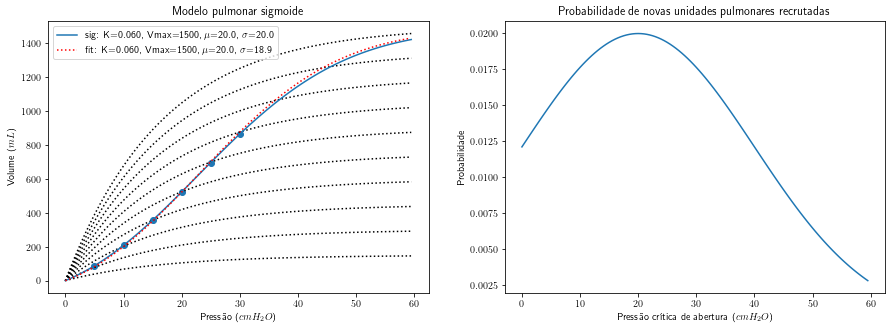

In [25]:
# simulando dados PV -> ESTES PARÂMETROS NÃO FITAM COM "LM"
Pmax = 60
Vmax = 1500
K = 0.06
mi = 20
sigma = 20

pressoes = [5, 10, 15, 20, 25, 30]
testa_ajuste(Pmax,Vmax,K,mi,sigma,pressoes)


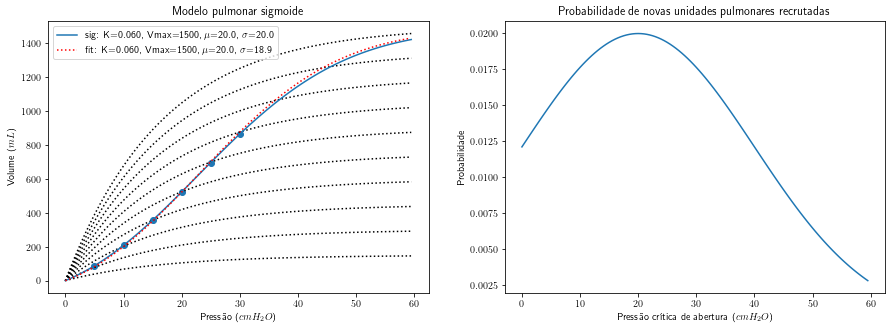

In [26]:
# simulando dados PV -> ESTES PARÂMETROS NÃO FITAM COM "LM"
Pmax = 60
Vmax = 1500
K = 0.06
mi = 20
sigma = 20

pressoes = [5, 10, 15, 20, 25, 30]
testa_ajuste(Pmax,Vmax,K,mi,sigma,pressoes,estimator="dogbox")


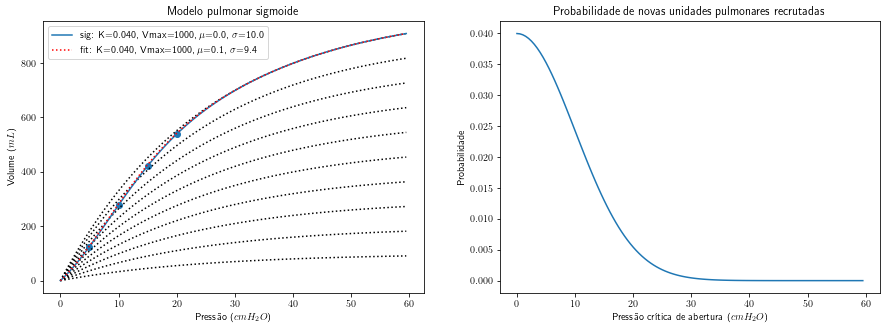

In [27]:
pressoes = [5, 10, 15, 20]
testa_ajuste(60,1000,0.04,0,10,pressoes) # Pmax,Vmax,K,mi,sigma,pressoes

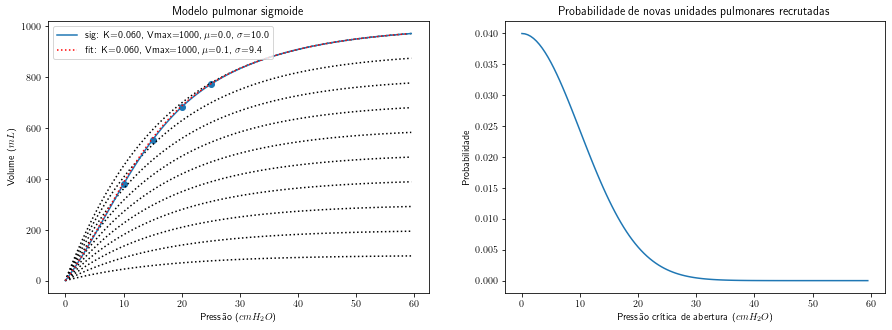

In [28]:
pressoes = [10, 15, 20, 25]
testa_ajuste(60,1000,0.06,0,10,pressoes) # Pmax,Vmax,K,mi,sigma,pressoes

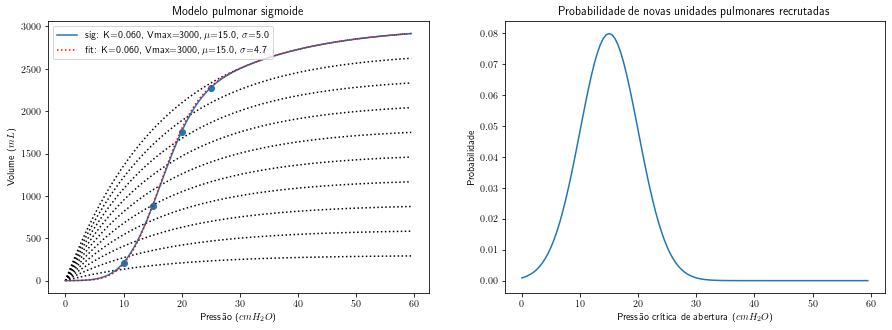

In [29]:
pressoes = [10, 15, 20, 25]
testa_ajuste(60,3000,0.06,15,5,pressoes) # Pmax,Vmax,K,mi,sigma,pressoes